In [1]:
import networkx as nx
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import seaborn as sns

In [2]:
from skyfield.api import load, wgs84

stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
satellites = load.tle_file(stations_url)
print('Loaded', len(satellites), 'satellites')
by_name = {sat.name: sat for sat in satellites}
satellite = by_name['STARLINK-1007']

# year, month, day, hour, minute, second
ts=load.timescale()
t = ts.now()
a=satellite.at(t)
lat, lon = wgs84.latlon_of(a)
print('Latitude:', lat)
print('Longitude:', lon)

Loaded 4219 satellites
Latitude: -43deg 07' 22.1"
Longitude: 24deg 13' 56.9"


In [3]:
from common import calculate_visible_satellites

# garching coordinates
observer_latitude = 48.2489
observer_longitude = 11.6532
observer_elevation = 0

visible_satellites = calculate_visible_satellites(
    observer_latitude, observer_longitude, observer_elevation, distance_km=800
)

for sat, alt, az in visible_satellites:
    print(sat.name)
    # print(f"Satellite: {sat}")
    # print(f"Altitude: {alt.degrees} degrees")
    # print(f"Azimuth: {az.degrees} degrees")

STARLINK-1511
STARLINK-2001
STARLINK-5133
STARLINK-5135
STARLINK-5465
STARLINK-5435
STARLINK-5749


In [4]:
def idplot(base,hops,_type,method, host=None):
    G = nx.Graph()
    g = {}
    for file in os.listdir(base):
        filename = os.fsdecode(file)
        if _type in filename and method in filename:
            with open(base + filename, "r") as csvfile:
                d = list(csv.reader(csvfile))
                for r in range(len(d)-(30-hops)):
                    ip1 = d[r][2]
                    ip2 = d[r + 1][2]
                    effe = ["*", "ip"]
                    if ip1 not in effe and ip2 not in effe:
                        if ip1 not in g:
                            g[ip1] = []
                        if ip2 not in g[ip1]:
                            g[ip1].append(ip2)

    for k, v in g.items():
        G.add_node(k)
        for i in v:
            G.add_edge(k, i)

    return G

def draw(G):
    _,degree = map(list, zip(*G.degree())) 
    nx.draw_kamada_kawai(
            G,
            node_color=range(len(G.degree())),
            cmap=plt.cm.GnBu,
            # node_size=[(v * 500) + 1 for v in  degree],
            # with_labels=True,
        )

In [5]:
def cloud_draw(provider,hops,method):
    plt.figure(figsize=(10, 15))
    plt.subplot(3, 2, 1)   # Define 3 rows, 2 column, Activate subplot 1. 
    base = f"/home/rc/idp-castellotti-data/new-traceroutes/{provider}/"
    plt.subplot(321).set_title(f"{provider} starlink {hops} hops {method}")
    G=idplot(base=base,hops=8,_type="starlink",method=method)
    draw(G)
    plt.subplot(322).set_title(f"{provider} normal {hops} hops {method} ")
    G=idplot(base=base,hops=hops,_type="normal",method=method)
    draw(G)
    plt.show()

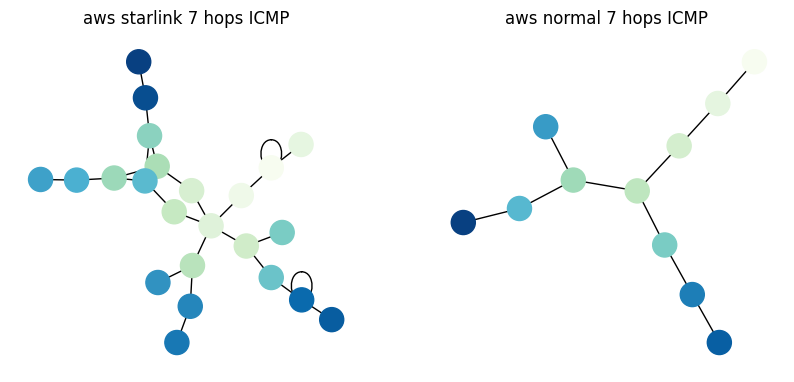

In [6]:
cloud_draw(provider="aws",hops=7,method="ICMP")

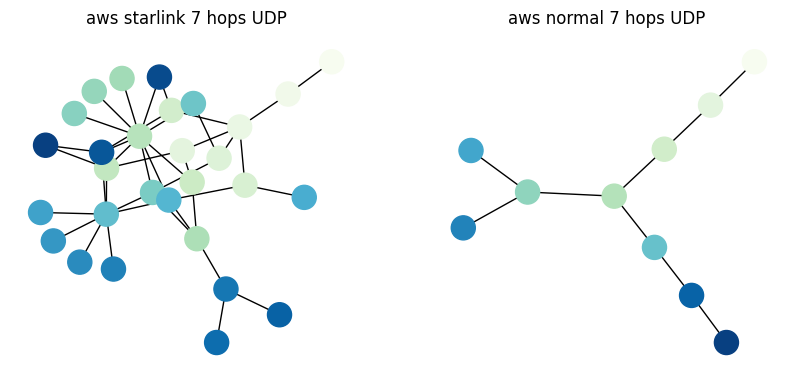

In [7]:
cloud_draw(provider="aws",hops=7,method="UDP")

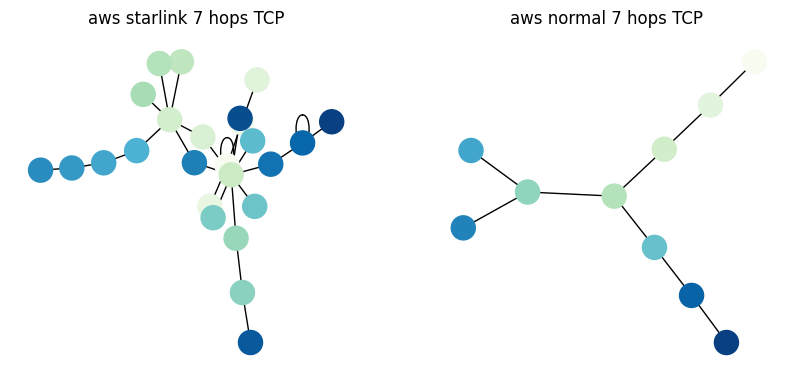

In [8]:
cloud_draw(provider="aws",hops=7,method="TCP")

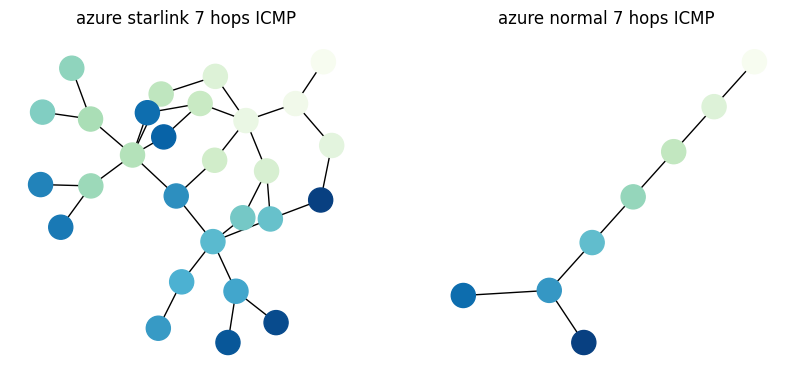

In [9]:
cloud_draw(provider="azure",hops=7,method="ICMP")

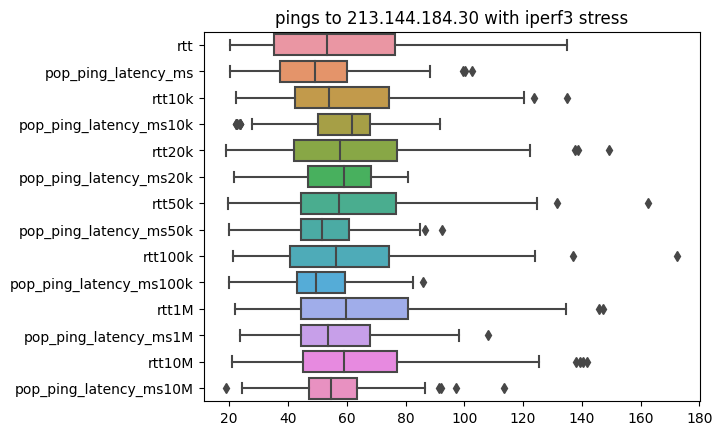

In [10]:
df0 = pd.read_csv("/home/rc/idp-castellotti-data/ping-bw-normal.csv")
df1 = pd.read_csv("/home/rc/idp-castellotti-data/ping-bw-10k.csv")
df2 = pd.read_csv("/home/rc/idp-castellotti-data/ping-bw-20k.csv")
df3 = pd.read_csv("/home/rc/idp-castellotti-data/ping-bw-50k.csv")
df4 = pd.read_csv("/home/rc/idp-castellotti-data/ping-bw-100k.csv")
df5 = pd.read_csv("/home/rc/idp-castellotti-data/ping-bw-1M.csv")
df6 = pd.read_csv("/home/rc/idp-castellotti-data/ping-bw-10M.csv")
df = pd.concat([df0, df1, df2, df3, df4, df5, df6], axis=1).reindex(df1.index)
sns.boxplot(
    data=df[
        [
            "rtt",
            "pop_ping_latency_ms",
            "rtt10k",
            "pop_ping_latency_ms10k",
            "rtt20k",
            "pop_ping_latency_ms20k",
            "rtt50k",
            "pop_ping_latency_ms50k",
            "rtt100k",
            "pop_ping_latency_ms100k",
            "rtt1M",
            "pop_ping_latency_ms1M",
            "rtt10M",
            "pop_ping_latency_ms10M",
        ]
    ],
    orient="h",
).set_title("pings to 213.144.184.30 with iperf3 stress")
plt.show()

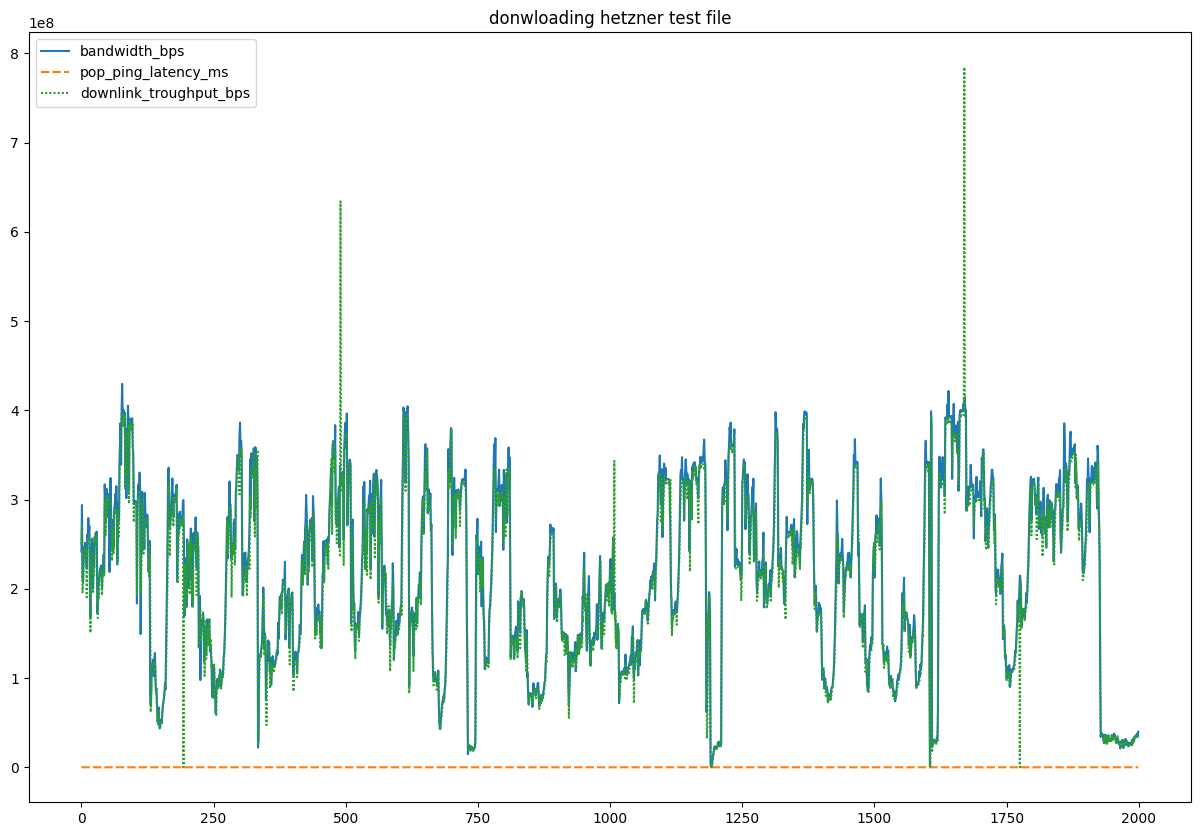

In [11]:
plt.figure(figsize=(15, 10))
df = pd.read_csv('/home/rc/idp-castellotti/large_file_download.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], format ='%Y-%m-%d %H:%M:%S.%f')
sns.lineplot(data=df[:2000],dashes=True)
plt.title("donwloading hetzner test file")
plt.show()

# while true; do wget -4 https://speed.hetzner.de/10GB.bin --report-speed=bits -O /dev/null; done
# sudo ip route add 88.198.248.254  via 192.168.1.1
# while true; do wget -4  http://ftp.de.debian.org/debian-cd/current/amd64/iso-dvd/debian-12.0.0-amd64-DVD-1.iso --report-speed=bits -O /dev/null; done
# while true; do wget -4  http://mirror.netcologne.de/debian-cd/current/amd64/iso-dvd/debian-12.0.0-amd64-DVD-1.iso --report-speed=bits -O /dev/null; done
# while true; do wget -4  http://mirror.23media.com//debian-cd/current/amd64/iso-dvd/debian-12.0.0-amd64-DVD-1.iso --report-speed=bits -O /dev/null; done
# http://mirror.23media.com//debian-cd/current/amd64/iso-dvd/debian-12.0.0-amd64-DVD-1.iso

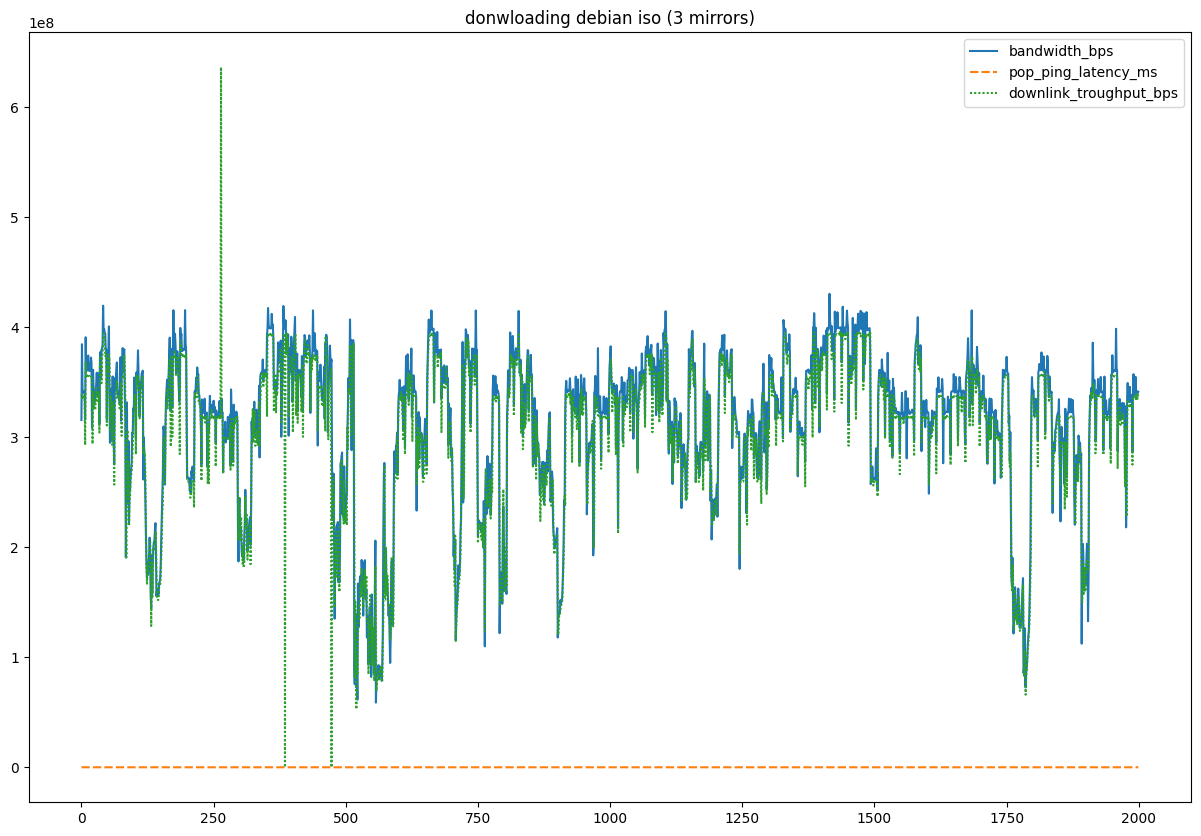

In [12]:
plt.figure(figsize=(15, 10))
df = pd.read_csv('/home/rc/idp-castellotti/large_file_download_3parallel.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], format ='%Y-%m-%d %H:%M:%S.%f')
sns.lineplot(data=df[:2000],dashes=True)
plt.title("donwloading debian iso (3 mirrors)")
plt.show()

# while true; do wget -4 https://speed.hetzner.de/10GB.bin --report-speed=bits -O /dev/null; done
# sudo ip route add 88.198.248.254  via 192.168.1.1
# while true; do wget -4  http://ftp.de.debian.org/debian-cd/current/amd64/iso-dvd/debian-12.0.0-amd64-DVD-1.iso --report-speed=bits -O /dev/null; done
# while true; do wget -4  http://mirror.netcologne.de/debian-cd/current/amd64/iso-dvd/debian-12.0.0-amd64-DVD-1.iso --report-speed=bits -O /dev/null; done
# while true; do wget -4  http://mirror.23media.com//debian-cd/current/amd64/iso-dvd/debian-12.0.0-amd64-DVD-1.iso --report-speed=bits -O /dev/null; done
# http://mirror.23media.com//debian-cd/current/amd64/iso-dvd/debian-12.0.0-amd64-DVD-1.iso

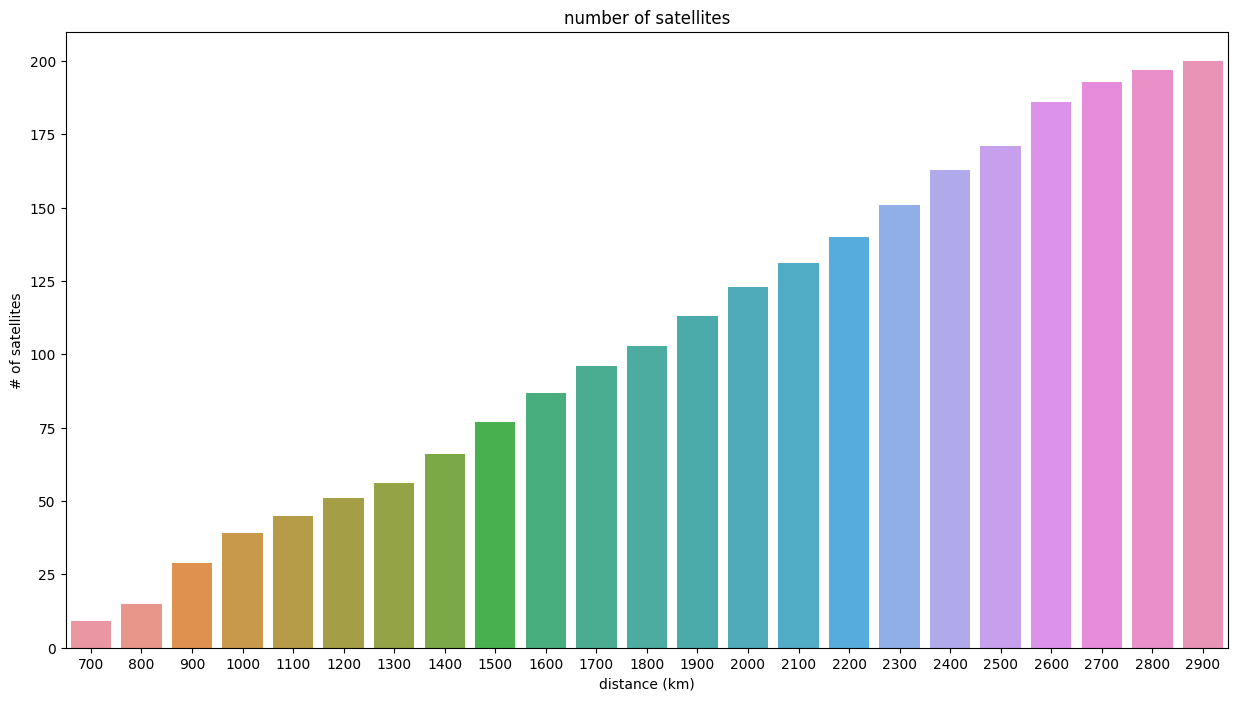

In [13]:
df = pd.read_csv('/home/rc/idp-castellotti-data/visible_satellites_variable_distance.csv')
plt.figure(figsize=(15, 8))
sns.countplot(x=df["distance"]).set_title("number of satellites")
plt.ylabel("# of satellites")
plt.xlabel("distance (km)")
plt.show()

In [14]:
# df0 = pd.read_csv("/home/rc/idp-castellotti-data/hist2.csv")
# df1 = pd.read_csv("/home/rc/idp-castellotti-data/hist3.csv")
# df2 = pd.read_csv("/home/rc/idp-castellotti-data/history.csv")
# df = pd.concat([df0, df1, df2], axis=1).reindex(df1.index)
# df.head()
# df.to_csv("/home/rc/idp-castellotti-data/hist.csv")

In [15]:
# df=pd.read_csv("/home/rc/idp-castellotti-data/hist.csv")
# df=df[:200]
# plt.figure(figsize=(20, 10))
# sns.lineplot(df)    

In [16]:
def split_non_consequtive(data):
    data = iter(data)
    val = next(data)
    chunk = []
    try:
        while True:
            chunk.append(val)
            val = next(data)
            if val[0] != chunk[-1][0] + 1:
                yield chunk
                chunk = []
    except StopIteration:
        if chunk:
            yield chunk

In [17]:
import random
from datetime import datetime
from collections import defaultdict
cnx = sqlite3.connect("satellites.sqlite")
satellites = cnx.execute("SELECT * FROM satellites").fetchall()
sats=defaultdict(list)
for sat in satellites:
    sats[sat[3]].append([sat[1], round(sat[2]), sat[3]])

segments=defaultdict(list)
count=0
for k in sats:
    if count==10000:
        break
    count+=1
    for i in split_non_consequtive(sats[k]):
        segments[k].append((datetime.fromtimestamp(i[0][1]),datetime.fromtimestamp(i[-1][1])))
import pprint

# how long we see satellites for
for s in random.choices(satellites,k=20):
    sat=s[3]
    current_sat=segments[sat]
    print(sat)
    for s in current_sat:
        print(s[1]-s[0])

STARLINK-6318
0:02:29
0:03:06
0:02:17
0:01:22
0:03:04
0:03:04
0:01:23
0:02:13
0:03:04
0:02:49
STARLINK-1049
0:02:44
0:02:27
0:00:49
0:02:59
0:02:27
0:01:38
0:03:16
0:01:54
0:02:11
0:03:16
STARLINK-4060
0:01:05
0:01:55
0:02:27
0:02:26
0:02:28
0:02:12
0:01:38
0:00:33
STARLINK-3270
0:02:11
0:02:27
0:02:27
0:02:27
0:02:10
0:01:38
STARLINK-4371
0:02:28
0:02:12
0:02:11
0:02:10
0:02:13
0:02:27
0:02:10
0:02:11
0:02:11
0:02:11
0:02:11
0:02:10
0:02:10
0:02:27
STARLINK-2754
0:01:05
0:01:54
0:02:27
0:02:43
0:02:28
0:01:55
0:01:22
STARLINK-3946
0:00:48
0:01:54
0:02:26
0:02:27
0:02:27
0:02:27
0:01:57
0:01:06
STARLINK-4282
0:01:06
0:01:59
0:02:26
0:02:27
0:02:44
0:02:10
0:01:55
0:01:06
STARLINK-5580
0:01:05
0:01:22
0:02:10
0:02:27
0:02:10
0:01:05
STARLINK-3252
0:02:43
0:02:27
0:02:10
0:01:22
0:01:05
0:01:54
STARLINK-3297
0:01:06
0:01:54
0:02:28
0:02:27
0:02:31
0:02:11
0:01:54
0:00:49
STARLINK-4474
0:01:05
0:02:10
0:02:10
0:02:43
0:02:26
0:02:10
0:01:54
0:00:50
STARLINK-3884
0:01:54
0:01:05
0:01:21
0:

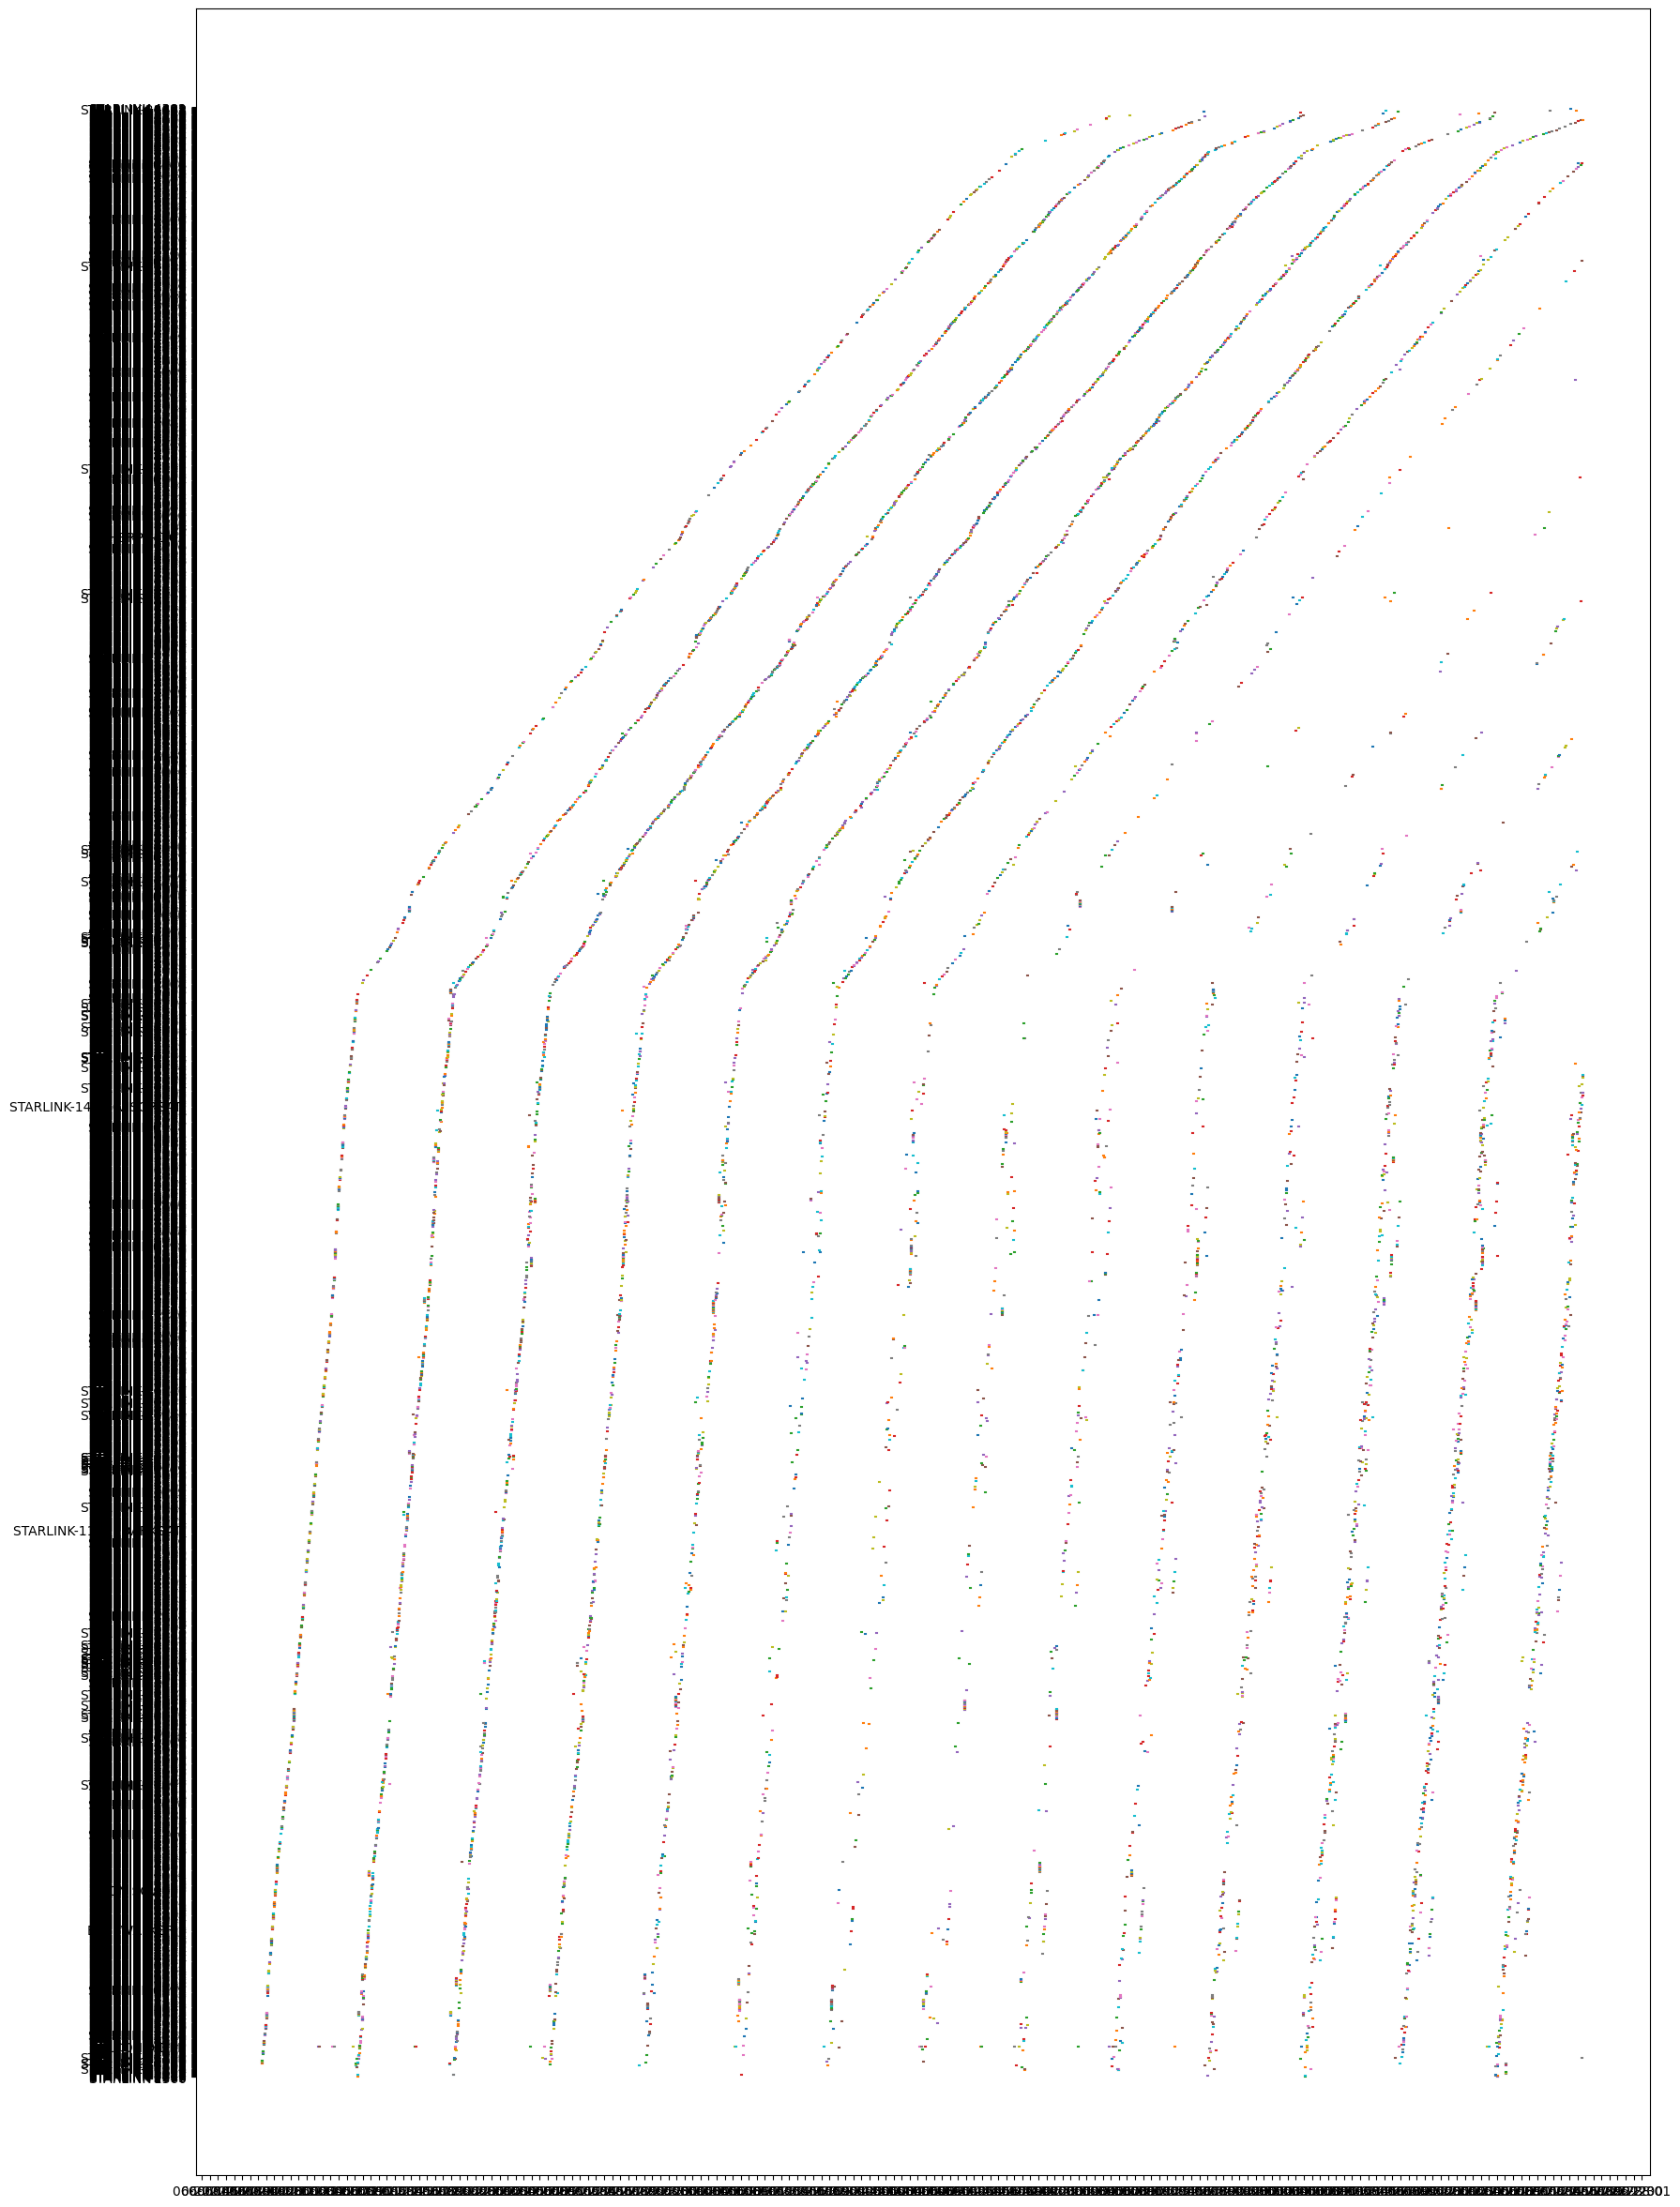

In [18]:
import matplotlib.dates as mdates
# we need data in this format: https://stackoverflow.com/a/12291380
plt.figure(figsize=(20, 30))
for y in segments:
    for seg in segments[y]:
        plt.plot(seg, [y, y])
plt.gca().xaxis.set_major_locator(mdates.HourLocator())

Text(0.5, 1.0, 'Histogram of Satellites in 15-second Intervals')

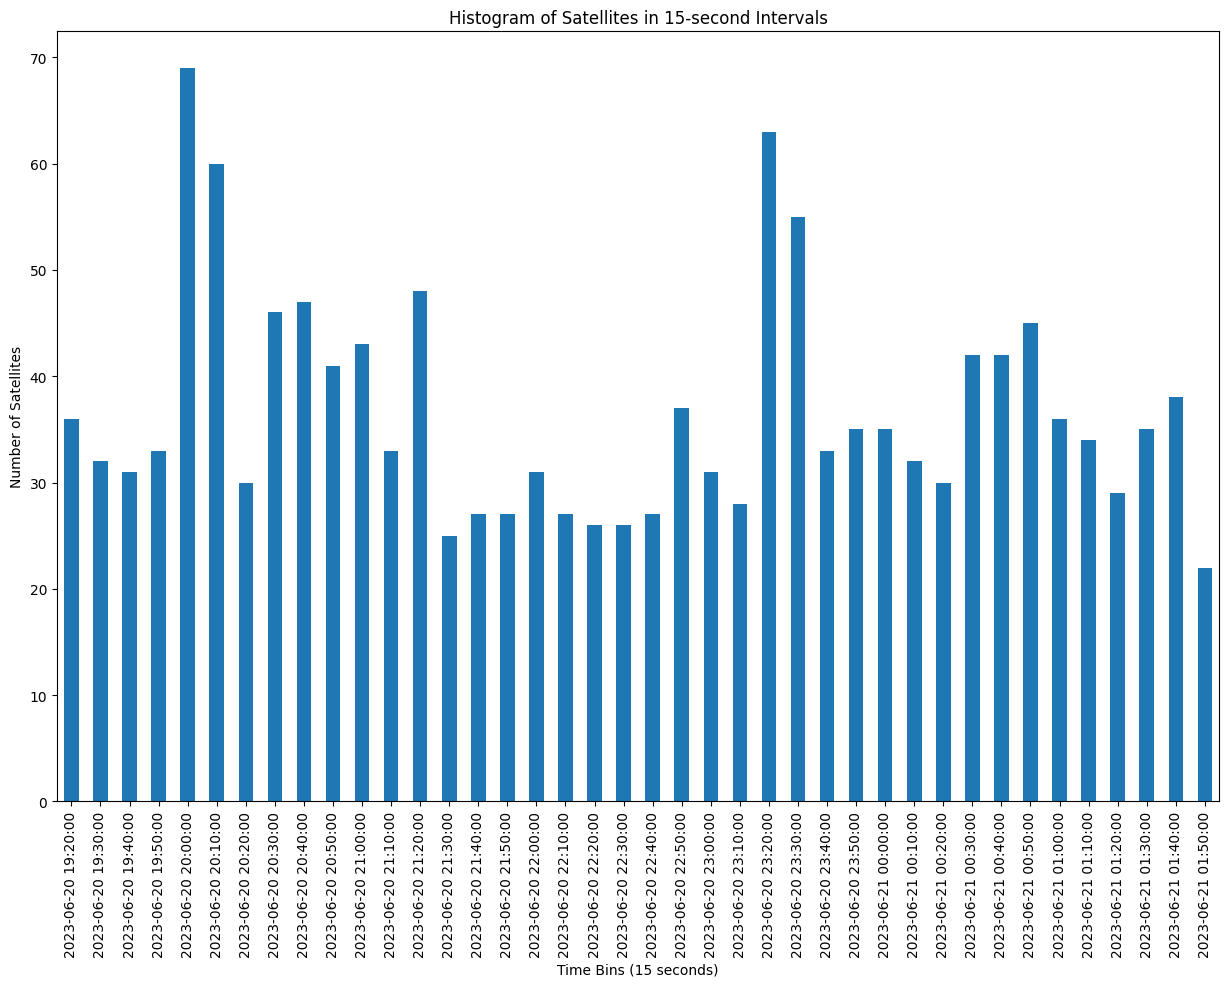

In [19]:

cnx = sqlite3.connect("satellites.sqlite")
df=pd.read_sql("select * from satellites",cnx)
df=df[:10000]
df['timestamp'] = pd.to_datetime(df['ts'],unit='s')
df.set_index('timestamp', inplace=True)
hist_data = df['satname'].resample('600S').nunique()
hist_data.plot(kind='bar', figsize=(15, 10))
plt.xlabel('Time Bins (15 seconds)')
plt.ylabel('Number of Satellites')
plt.title('Histogram of Satellites in 15-second Intervals')
